In [1]:
# REFERENCE FROM https://www.kaggle.com/code/shreyachaturvedi1231/pretrained1

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_recall_curve, auc

In [3]:
BASE_DIR = "./dataset/"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

IMAGE_DIR = os.path.join(BASE_DIR, "images")
IMAGE_FILES = {os.path.basename(f): f for f in glob.glob(os.path.join(IMAGE_DIR, "*.png"))}

print(f"Total images found: {len(IMAGE_FILES)}")

Total images found: 112120


In [ ]:
# (INCLUDING 'NO FINDING')
# Load CSV and extract relevant columns 
df = pd.read_csv(CSV_PATH)
df = df[['Image Index', 'Finding Labels']]
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Define the disease labels you're interested in
labels = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Emphysema', 'Effusion', 'Infiltration', 'Atelectasis']

# One-hot encode the disease labels
for label in labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

# Compute the total number of labels per row (helps identify "No Finding")
df['has_label'] = df[labels].sum(axis=1)

# Split into disease and "No Finding" groups
disease_df = df[df['has_label'] > 0]
no_finding_df = df[df['has_label'] == 0]

# Downsample "No Finding" rows to balance the dataset
downsample_ratio = 0.3  # You can tune this ratio
desired_no_finding = int(len(disease_df) * downsample_ratio)
downsampled_no_finding_df = no_finding_df.sample(n=desired_no_finding, random_state=42)

# Combine and shuffle the final dataset
balanced_df = pd.concat([disease_df, downsampled_no_finding_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Train-validation split
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

In [ ]:
# (EXCLUDING 'NO FINDING')
# Load CSV and extract relevant columns 
df = pd.read_csv(CSV_PATH) 
df = df[['Image Index', 'Finding Labels']]
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

labels = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Emphysema', 'Effusion', 'Infiltration', 'Atelectasis']

# One-hot encode the labels
for label in labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

# Optional: keep 'No Finding' rows but assign all-zero labels
df['has_label'] = df[labels].sum(axis=1)
df = df[df['has_label'] > 0]  # If you want to exclude "No Finding" images, comment this out to keep them

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# With augmentation
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Add the 'path' column to train_df and val_df
train_df['path'] = train_df['Image Index'].map(IMAGE_FILES)
val_df['path'] = val_df['Image Index'].map(IMAGE_FILES)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=False
)

Found 41156 validated image filenames.
Found 10290 validated image filenames.


In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(labels), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Compute per-class weights (inverse frequency)
class_freq = train_df[labels].sum()
class_weights = 1. / (class_freq + 1e-6)
class_weights = class_weights / class_weights.sum()  # normalize to sum to 1
class_weights_tensor = K.constant(class_weights.values)  # convert to tensor

# Updated focal loss with per-class alpha
def focal_loss(gamma=2., alpha=class_weights_tensor):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Clip predictions to avoid log(0)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return K.mean(alpha_t * K.pow(1 - p_t, gamma) * bce, axis=-1)  # Mean over batch
    return loss

# Unfreeze top layers of base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile model
model.compile(
    optimizer=Adam(1e-4),
    loss=focal_loss(),  # custom loss with per-class balancing
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("thoracic_classifierV7.h5", save_best_only=True)
]

# Train
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
2573/2573 [==============================] - 2224s 860ms/step - loss: 0.0154 - accuracy: 0.2096 - val_loss: 0.0149 - val_accuracy: 0.2767
Epoch 2/25
2573/2573 [==============================] - 2034s 790ms/step - loss: 0.0145 - accuracy: 0.2267 - val_loss: 0.0147 - val_accuracy: 0.2021
Epoch 3/25
2573/2573 [==============================] - 2032s 790ms/step - loss: 0.0143 - accuracy: 0.2372 - val_loss: 0.0143 - val_accuracy: 0.2673
Epoch 4/25
2573/2573 [==============================] - 2157s 838ms/step - loss: 0.0143 - accuracy: 0.2440 - val_loss: 0.0142 - val_accuracy: 0.2240
Epoch 5/25
2573/2573 [==============================] - 2216s 861ms/step - loss: 0.0142 - accuracy: 0.2526 - val_loss: 0.0145 - val_accuracy: 0.1803
Epoch 6/25
2573/2573 [==============================] - 2135s 830ms/step - loss: 0.0141 - accuracy: 0.2546 - val_loss: 0.0140 - val_accuracy: 0.3017
Epoch 7/25
2573/2573 [==============================] - 2147s 834ms/step - loss: 0.0140 - accuracy: 0.2595

644/644 [==============================] - 226s 348ms/step


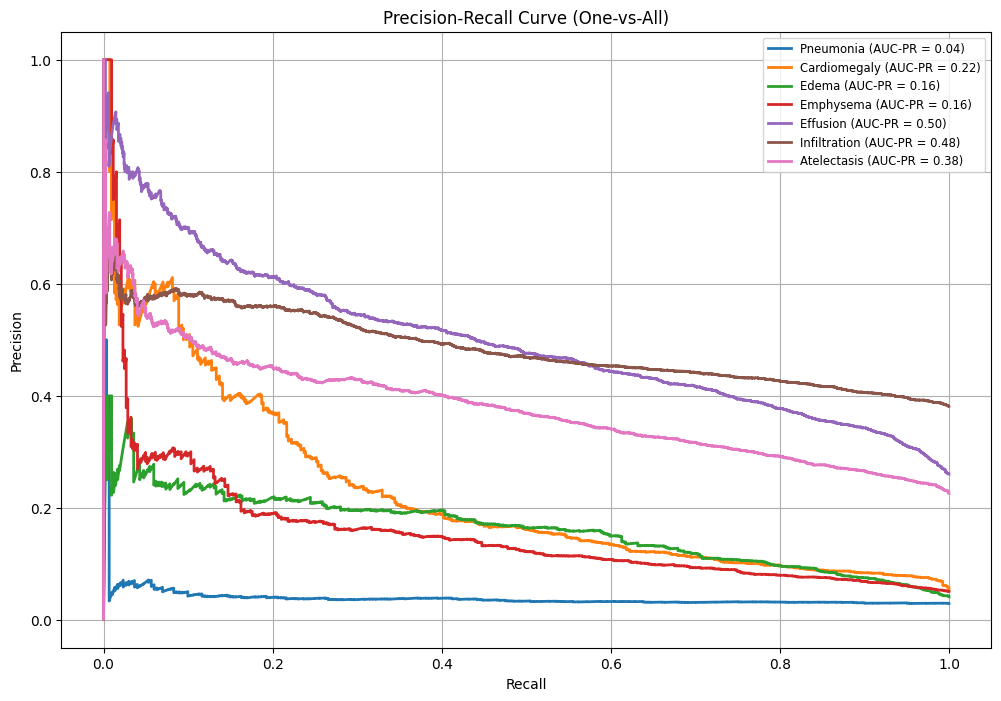

In [11]:
# True and predicted labels
y_true = val_gen.labels
y_pred = model.predict(val_gen)

# Compute Precision-Recall and AUC-PR for each class
precision = dict()
recall = dict()
auc_pr = dict()

for i in range(len(labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Plot
plt.figure(figsize=(12, 8))
for i in range(len(labels)):
    plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} (AUC-PR = {auc_pr[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-All)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
#model.save('thoracic_classifierV7.h5')  # Saves as HDF5 format
model.save('thoracic_classifierV7.keras')  # Saves as Keras format

## Testing the Model

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7374314..1.7183532].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.892388..1.8762784].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7374314..1.7183532].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5584737..1.7243621].



Image 1 probabilities:
Pneumonia: 74.58%
Cardiomegaly: 1.19%
Edema: 0.50%
Emphysema: 2.82%
Effusion: 6.35%
Infiltration: 56.70%
Atelectasis: 17.09%

Image 2 probabilities:
Pneumonia: 41.46%
Cardiomegaly: 76.19%
Edema: 3.06%
Emphysema: 0.74%
Effusion: 8.69%
Infiltration: 46.88%
Atelectasis: 5.38%

Image 3 probabilities:
Pneumonia: 74.58%
Cardiomegaly: 1.19%
Edema: 0.50%
Emphysema: 2.82%
Effusion: 6.35%
Infiltration: 56.70%
Atelectasis: 17.09%

Image 4 probabilities:
Pneumonia: 68.52%
Cardiomegaly: 1.72%
Edema: 0.32%
Emphysema: 3.61%
Effusion: 7.00%
Infiltration: 53.55%
Atelectasis: 22.84%


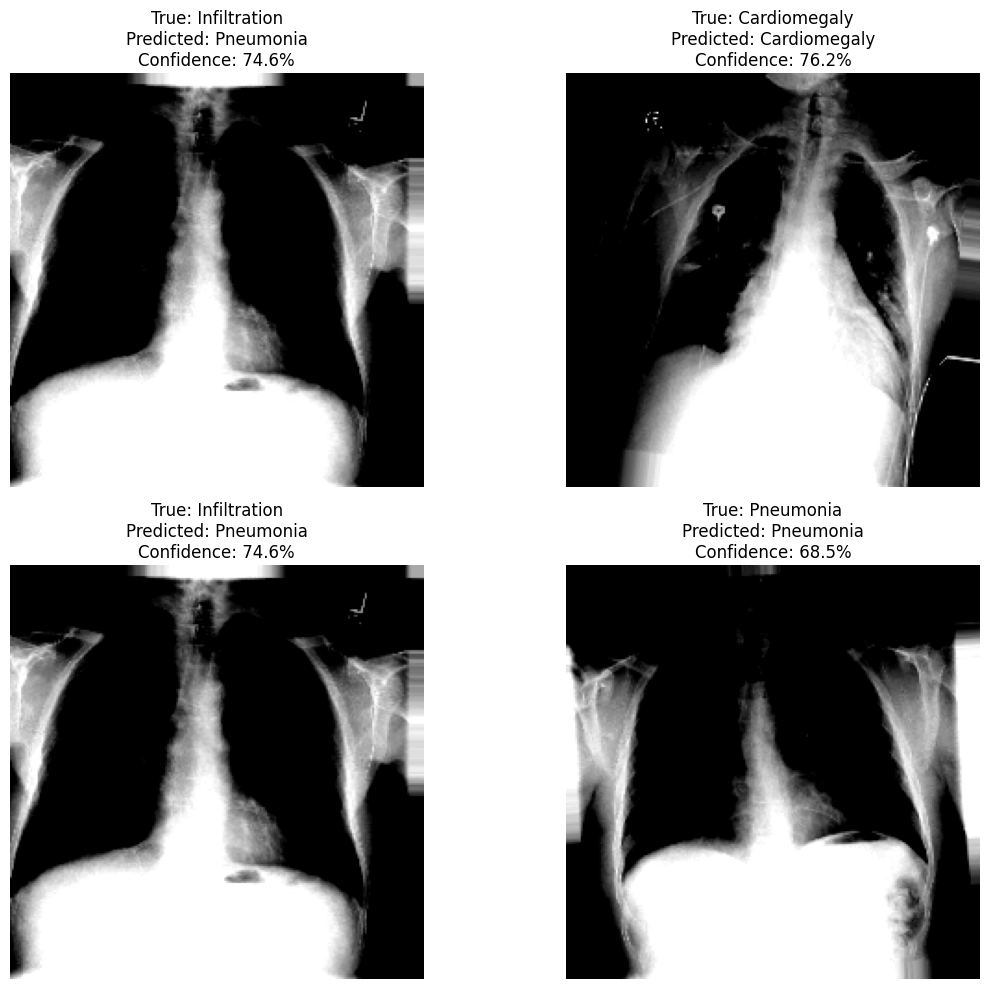

In [ ]:
# Get a batch of images and labels from the validation generator
batch_images, batch_labels = next(train_gen)

# Make predictions on the batch
batch_preds = model.predict(batch_images)

# Define disease names mapping (based on your label assignments)
disease_names = ["Pneumonia", "Cardiomegaly", "Edema", 
                "Emphysema", "Effusion", "Infiltration", "Atelectasis"]

# Create a figure with 2x2 grid to display 4 random images
plt.figure(figsize=(12, 10))

# Display 4 random images from the batch
for i in range(4):
    # Choose a random image from the batch
    idx = np.random.randint(len(batch_images))
    img = batch_images[idx]
    
    # Get true and predicted labels
    true_label_idx = np.argmax(batch_labels[idx])
    pred_label_idx = np.argmax(batch_preds[idx])
    
    # Get disease names
    true_disease = disease_names[true_label_idx]
    pred_disease = disease_names[pred_label_idx]
    
    # Calculate confidence percentage
    confidence = batch_preds[idx][pred_label_idx] * 100
    
    # Plot the image in a subplot
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_disease}\nPredicted: {pred_disease}\nConfidence: {confidence:.1f}%")
    plt.axis('off')
    
    # Print detailed probabilities for this image
    print(f"\nImage {i+1} probabilities:")
    for j, disease in enumerate(disease_names):
        prob = batch_preds[idx][j] * 100
        print(f"{disease}: {prob:.2f}%")

plt.tight_layout()
plt.show()